In [20]:
import numpy as np
from multiprocessing import Process, cpu_count, RawArray
from time import time

import matplotlib.pyplot as plt

In [21]:
MAX_UNITS = cpu_count()
MAX_X = 64
MAX_Y = 64

_vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
vector = RawArray('i',_vector)
_vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)
vector_out = RawArray('i',_vector_out)

In [22]:
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y)

In [23]:
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1 , y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1 , y) ] + vector[ indice(x + 1, y + 1) ]



In [24]:
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas 
# vivirán y cuales no 
#
def conway(low_limit = 0, high_limit = MAX_X):
  for i in range(low_limit,high_limit):
    for j in range(0,MAX_Y):
      n = vecinos(i,j)
      valor = 0
      if vector[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector[ indice(i,j) ] == 0 and n == 3:
        valor = 1
      vector_out[ indice(i,j) ] = valor

[[1 0 1 ... 1 0 1]
 [1 1 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]
 ...
 [0 1 0 ... 0 1 0]
 [1 0 1 ... 1 1 0]
 [0 0 1 ... 1 0 0]]

El tiempo que tomó calcular 0.5162796974182129


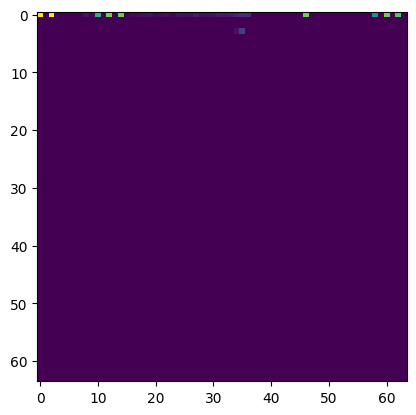

In [26]:
print(np.frombuffer(vector, dtype = np.int32).reshape(MAX_X, MAX_Y))
# Variables usadas para hacer la partición de las filas que trabajará cada
# proceso
stride = np.int32(MAX_X / MAX_UNITS)
count = np.int32(0)
workers = [] # arreglo que almacenará aquellos procesos que se crearán
for t in range(MAX_UNITS):
    worker = Process(target = conway,
                    args = (count, np.int32(count + stride)))
    workers.append(worker)
    #print(count)
    count = count + stride
# Ciclo que lanza la ejecución de los procesos que se crearon
t1 = time()
for worker in workers:
    worker.start()
# Ciclo que espera por la terminación de todos los procesos que se lanzaron
for worker in workers:
    worker.join()
t2 = time()
print()
#print(np.frombuffer(vector_out, dtype = np.int32).reshape(MAX_X, MAX_Y))
print(f"El tiempo que tomó calcular {t2 - t1}")
fig = plt.figure()
plt.imshow(np.frombuffer(vector_out, dtype=np.int32).reshape(MAX_X,MAX_Y))
plt.show() 